# DeepXDE教程2：2D热传导方程求解

## 🎯 教程目标
本教程将介绍如何使用DeepXDE求解2D时变偏微分方程。你将学会：
- 处理多维时空PDE问题
- 设置初始条件和边界条件
- 可视化时空演化过程
- 分析2D问题的训练策略

## 📚 背景知识

### 2D热传导方程
热传导方程是经典的抛物型PDE，描述了热量在介质中的传播过程：

**方程**：
$$\frac{\partial u}{\partial t} = \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}, \quad (x,y) \in [0,1]^2, \quad t \in [0,1]$$

**边界条件**：
$$u(x,y,t) = 0, \quad (x,y) \in \partial\Omega$$

**初始条件**：
$$u(x,y,0) = \sin(\pi x)\sin(\pi y)$$

**解析解**：
$$u(x,y,t) = e^{-2\pi^2 t} \sin(\pi x) \sin(\pi y)$$

### 与1D问题的区别
- **输入维度**: 从1D (x) 增加到3D (x,y,t)
- **复杂性**: 时空耦合，需要同时满足初始和边界条件
- **计算量**: 显著增加，需要更多训练点和时间
- **可视化**: 需要多时刻的2D热图展示

## 1. 环境准备

In [1]:
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
import deepxde as dde

# 检查DeepXDE版本和后端
print(f"DeepXDE版本: {dde.__version__}")
print(f"当前后端: {dde.backend.backend_name}")

# 设置matplotlib参数
plt.rcParams['font.sans-serif'] = ['Arial', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 设置随机种子
np.random.seed(42)
dde.config.set_random_seed(42)

print("✅ 环境准备完成")

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


DeepXDE版本: 1.14.0
当前后端: pytorch
✅ 环境准备完成


## 2. 定义2D热传导PDE

In [2]:
def pde_2d_heat(x, y):
    """
    定义2D热传导方程
    
    Args:
        x: 输入坐标 [x, y, t] (N, 3)
        y: 神经网络输出 u(x,y,t) (N, 1)
        
    Returns:
        PDE残差 (N, 1)
    """
    # 计算各个偏导数
    dy_t = dde.grad.jacobian(y, x, i=0, j=2)   # ∂u/∂t
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)   # ∂²u/∂x²
    dy_yy = dde.grad.hessian(y, x, i=1, j=1)   # ∂²u/∂y²
    
    # 热传导方程: ∂u/∂t - (∂²u/∂x² + ∂²u/∂y²) = 0
    return dy_t - dy_xx - dy_yy

print("✅ PDE函数定义完成")

✅ PDE函数定义完成


## 3. 定义时空域

In [3]:
# 定义时空域：[0,1] × [0,1] × [0,1]
geom_2d = dde.geometry.Rectangle([0, 0], [1, 1])  # 空间域
time_domain = dde.geometry.TimeDomain(0, 1)       # 时间域
geomtime = dde.geometry.GeometryXTime(geom_2d, time_domain)  # 时空域

print("✅ 2D热传导PDE定义完成")
print(f"时空域类型: {type(geomtime)}")
print(f"空间域: [0,1] × [0,1]")
print(f"时间域: [0,1]")

✅ 2D热传导PDE定义完成
时空域类型: <class 'deepxde.geometry.timedomain.GeometryXTime'>
空间域: [0,1] × [0,1]
时间域: [0,1]


## 4. 定义边界条件和初始条件

In [4]:
# 定义边界条件和初始条件
def boundary_2d(x, on_boundary):
    """空间边界条件"""
    return on_boundary

def initial_condition(x):
    """初始条件：u(x,y,0) = sin(πx)sin(πy)"""
    return np.sin(np.pi * x[:, 0:1]) * np.sin(np.pi * x[:, 1:2])

# 解析解（用于验证）
def analytical_solution_2d(x):
    """解析解：u(x,y,t) = exp(-2π²t) * sin(πx) * sin(πy)"""
    return (np.exp(-2 * np.pi**2 * x[:, 2:3]) * 
            np.sin(np.pi * x[:, 0:1]) * 
            np.sin(np.pi * x[:, 1:2]))

# 创建边界条件和初始条件
bc_2d = dde.icbc.DirichletBC(geomtime, lambda x: 0, boundary_2d)
ic_2d = dde.icbc.IC(geomtime, initial_condition, lambda _, on_initial: on_initial)

print("✅ 边界条件和初始条件定义完成")

✅ 边界条件和初始条件定义完成


## 5. 可视化初始条件

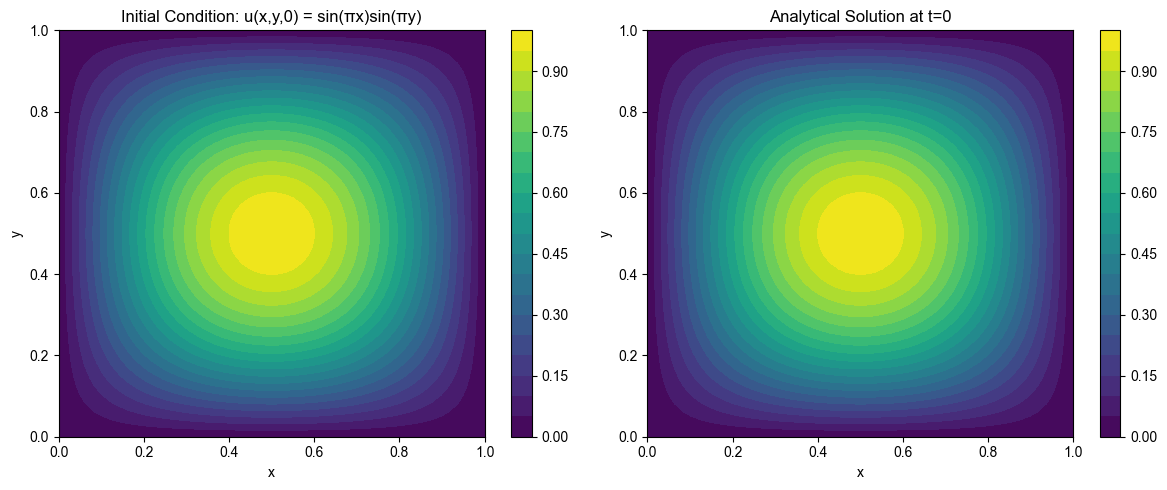

初始条件最大值: 0.9990
初始条件最小值: 0.0000


In [5]:
# 可视化初始条件
x_test = np.linspace(0, 1, 50)
y_test = np.linspace(0, 1, 50)
X_test, Y_test = np.meshgrid(x_test, y_test)
points_init = np.stack([X_test.flatten(), Y_test.flatten(), np.zeros_like(X_test.flatten())], axis=1)

# 计算初始条件
u_init = initial_condition(points_init).reshape(X_test.shape)
u_analytical_init = analytical_solution_2d(points_init).reshape(X_test.shape)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 初始条件
im1 = axes[0].contourf(X_test, Y_test, u_init, levels=20, cmap='viridis')
axes[0].set_title('Initial Condition: u(x,y,0) = sin(πx)sin(πy)')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
plt.colorbar(im1, ax=axes[0])

# 解析解t=0（应该相同）
im2 = axes[1].contourf(X_test, Y_test, u_analytical_init, levels=20, cmap='viridis')
axes[1].set_title('Analytical Solution at t=0')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

print(f"初始条件最大值: {np.max(u_init):.4f}")
print(f"初始条件最小值: {np.min(u_init):.4f}")

## 6. 创建PDE数据

In [6]:
# 创建2D PDE数据
data_2d = dde.data.TimePDE(
    geomtime,
    pde_2d_heat,
    [bc_2d, ic_2d],
    num_domain=2500,
    num_boundary=80,
    num_initial=100,
    solution=analytical_solution_2d,
    num_test=1000
)

print("✅ 2D热传导问题设置完成")
print(f"域内点数: {data_2d.num_domain}")
print(f"边界点数: {data_2d.num_boundary}")
print(f"初始点数: {data_2d.num_initial}")
print(f"测试点数: {data_2d.num_test}")

✅ 2D热传导问题设置完成
域内点数: 2500
边界点数: 80
初始点数: 100
测试点数: 1000


## 7. 构建神经网络

In [7]:
# 构建2D网络
layer_size_2d = [3] + [50] * 4 + [1]  # 输入3维(x,y,t)，输出1维
net_2d = dde.nn.FNN(layer_size_2d, "tanh", "Glorot uniform")

print("✅ 神经网络构建完成")
print(f"网络结构: {layer_size_2d}")
print(f"输入维度: 3 (x, y, t)")
print(f"输出维度: 1 (u)")
print(f"激活函数: tanh")

# 估算参数数量
params = (3*50 + 50) + 3*(50*50 + 50) + (50*1 + 1)
print(f"参数数量: ~{params:,}")

✅ 神经网络构建完成
网络结构: [3, 50, 50, 50, 50, 1]
输入维度: 3 (x, y, t)
输出维度: 1 (u)
激活函数: tanh
参数数量: ~7,901


## 8. 训练模型

In [8]:
# 创建和训练2D模型
model_2d = dde.Model(data_2d, net_2d)
model_2d.compile("adam", lr=0.001, metrics=["l2 relative error"])

print("🚀 开始训练2D热传导模型...")
print("⚠️  注意：2D问题计算较慢，请耐心等待...")

# 训练（较少迭代以节省时间）
import time
start_time = time.time()

losshistory_2d, train_state_2d = model_2d.train(iterations=5000)

train_time = time.time() - start_time
print(f"✅ 2D模型训练完成！用时: {train_time:.1f}秒")

# 安全地访问训练结果
try:
    if hasattr(train_state_2d, 'metrics_test') and train_state_2d.metrics_test is not None:
        if hasattr(train_state_2d.metrics_test, '__len__') and len(train_state_2d.metrics_test) > 0:
            l2_error = float(train_state_2d.metrics_test[-1])
            print(f"最终L2误差: {l2_error:.6f}")
        else:
            l2_error = float(train_state_2d.metrics_test)
            print(f"最终L2误差: {l2_error:.6f}")
    else:
        # 如果没有metrics，显示损失
        if hasattr(train_state_2d.loss_train, '__len__'):
            train_loss = float(train_state_2d.loss_train[-1])
            test_loss = float(train_state_2d.loss_test[-1])
        else:
            train_loss = float(train_state_2d.loss_train)
            test_loss = float(train_state_2d.loss_test)
        print(f"最终训练损失: {train_loss:.6f}")
        print(f"最终测试损失: {test_loss:.6f}")
except Exception as e:
    print(f"⚠️ 访问训练结果时出错: {e}")
    print("💡 训练可能已完成，但结果访问方式需要调整")

Compiling model...
'compile' took 0.000140 s

🚀 开始训练2D热传导模型...
⚠️  注意：2D问题计算较慢，请耐心等待...
Training model...

🚀 开始训练2D热传导模型...
⚠️  注意：2D问题计算较慢，请耐心等待...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [3.02e-01, 3.50e-01, 9.39e-01]    [3.18e-01, 3.50e-01, 9.39e-01]    [4.21e+00]    
Step      Train loss                        Test loss                         Test metric   
0         [3.02e-01, 3.50e-01, 9.39e-01]    [3.18e-01, 3.50e-01, 9.39e-01]    [4.21e+00]    
1000      [4.54e-03, 3.29e-03, 1.78e-02]    [1.46e-03, 3.29e-03, 1.78e-02]    [3.25e-01]    
1000      [4.54e-03, 3.29e-03, 1.78e-02]    [1.46e-03, 3.29e-03, 1.78e-02]    [3.25e-01]    
2000      [1.81e-03, 9.33e-04, 3.94e-03]    [6.53e-04, 9.33e-04, 3.94e-03]    [1.67e-01]    
2000      [1.81e-03, 9.33e-04, 3.94e-03]    [6.53e-04, 9.33e-04, 3.94e-03]    [1.67e-01]    
3000      [1.18e-03, 5.79e-04, 2.97e-03]    [4.56e-04, 5.79e-04, 2.97e-03]    [1.34e-01]

## 9. 可视化2D结果

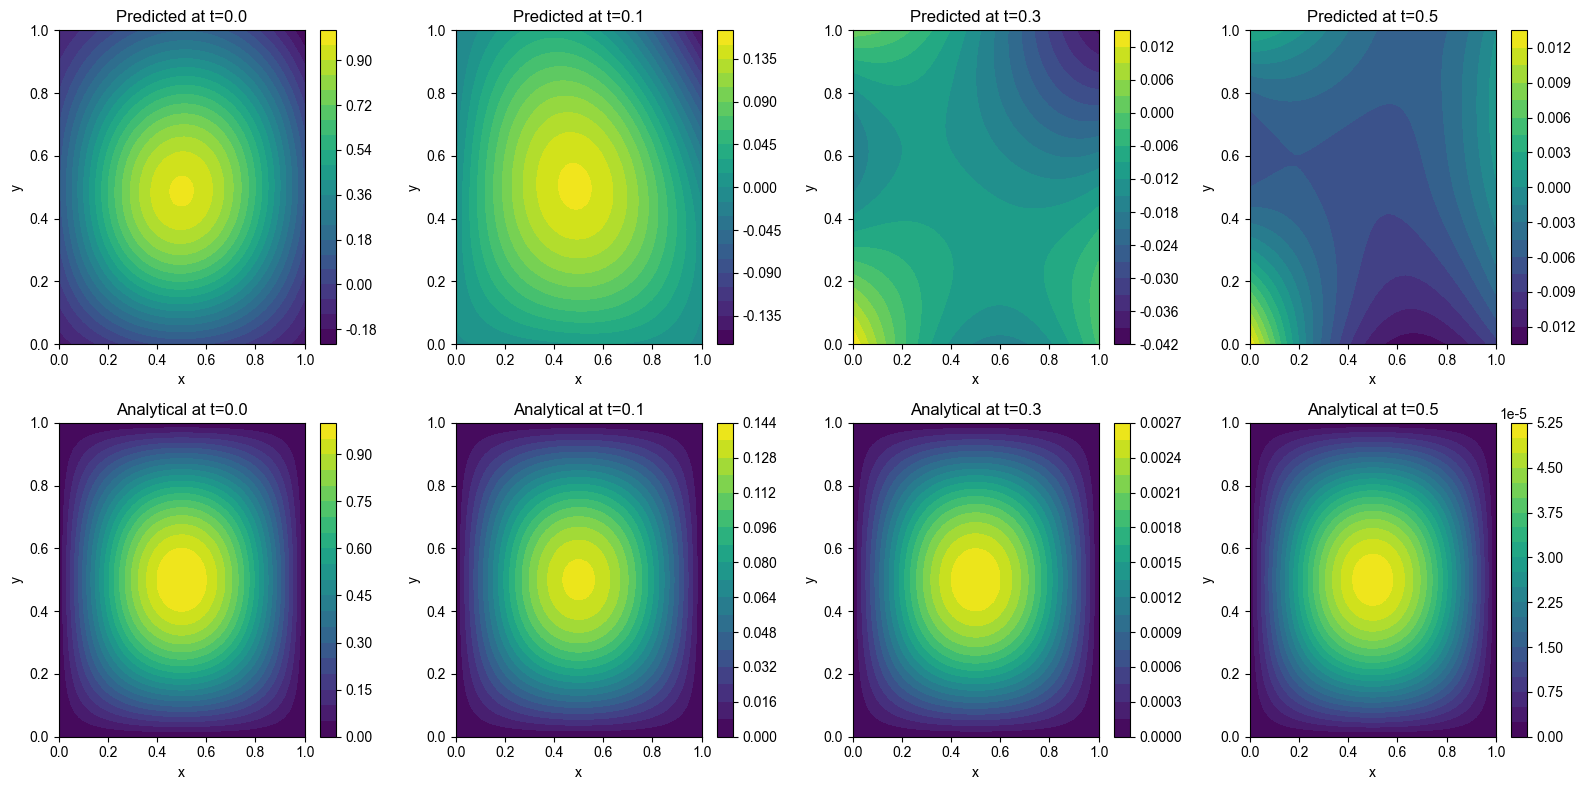

💡 观察热传导过程：
   - 随时间推移，温度场逐渐衰减
   - 边界保持零温度
   - 中心温度最高，向边界扩散


In [9]:
# 在不同时刻可视化解
times = [0.0, 0.1, 0.3, 0.5]
x_mesh = np.linspace(0, 1, 50)
y_mesh = np.linspace(0, 1, 50)
X, Y = np.meshgrid(x_mesh, y_mesh)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i, t in enumerate(times):
    # 创建测试点
    T = np.full_like(X, t)
    points = np.stack([X.flatten(), Y.flatten(), T.flatten()], axis=1)
    
    # 预测和解析解
    u_pred = model_2d.predict(points).reshape(X.shape)
    u_true = analytical_solution_2d(points).reshape(X.shape)
    
    # 绘制预测解
    im1 = axes[0, i].contourf(X, Y, u_pred, levels=20, cmap='viridis')
    axes[0, i].set_title(f'Predicted at t={t}')
    axes[0, i].set_xlabel('x')
    axes[0, i].set_ylabel('y')
    fig.colorbar(im1, ax=axes[0, i])
    
    # 绘制解析解
    im2 = axes[1, i].contourf(X, Y, u_true, levels=20, cmap='viridis')
    axes[1, i].set_title(f'Analytical at t={t}')
    axes[1, i].set_xlabel('x')
    axes[1, i].set_ylabel('y')
    fig.colorbar(im2, ax=axes[1, i])

plt.tight_layout()
plt.show()

print("💡 观察热传导过程：")
print("   - 随时间推移，温度场逐渐衰减")
print("   - 边界保持零温度")
print("   - 中心温度最高，向边界扩散")

## 10. 训练历史分析

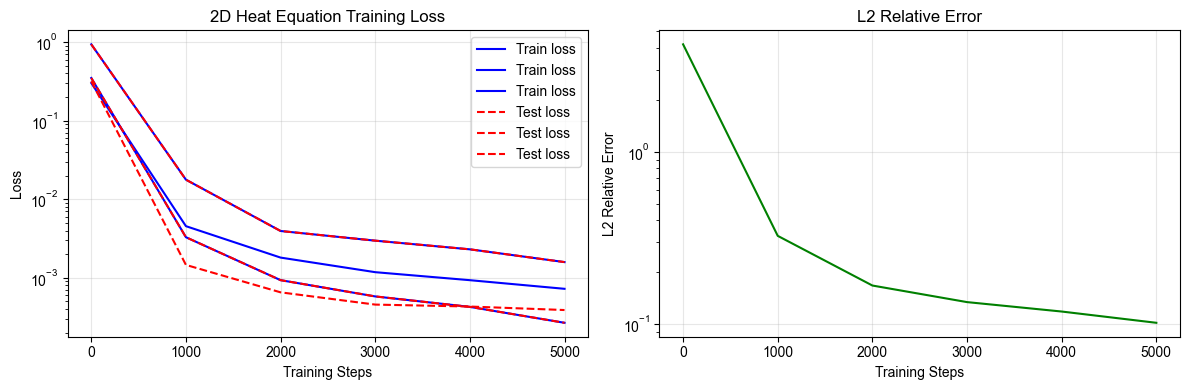

In [10]:
# 绘制训练历史
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(losshistory_2d.steps, losshistory_2d.loss_train, 'b-', label='Train loss')
plt.plot(losshistory_2d.steps, losshistory_2d.loss_test, 'r--', label='Test loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.title('2D Heat Equation Training Loss')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
if losshistory_2d.metrics_test:
    plt.plot(losshistory_2d.steps, np.array(losshistory_2d.metrics_test)[:, 0], 'g-')
    plt.xlabel('Training Steps')
    plt.ylabel('L2 Relative Error')
    plt.yscale('log')
    plt.title('L2 Relative Error')
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'No metrics available', 
             ha='center', va='center', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

## 11. 误差分析

In [11]:
# 详细误差分析
print("📊 2D热传导方程求解分析")
print("=" * 50)

# 在不同时刻计算误差
for t in [0.0, 0.2, 0.5, 1.0]:
    T_test = np.full_like(X, t)
    points_test = np.stack([X.flatten(), Y.flatten(), T_test.flatten()], axis=1)
    
    u_pred = model_2d.predict(points_test)
    u_true = analytical_solution_2d(points_test)
    
    # 计算各种误差
    abs_error = np.abs(u_pred - u_true)
    rel_error = abs_error / (np.abs(u_true) + 1e-8)
    l2_error = np.sqrt(np.mean(abs_error**2))
    max_error = np.max(abs_error)
    
    print(f"t = {t:.1f}:")
    print(f"  L2误差: {l2_error:.6f}")
    print(f"  最大误差: {max_error:.6f}")
    print(f"  平均相对误差: {np.mean(rel_error):.6f}")
    print()

print("💡 2D问题特点：")
print("  - 比1D问题复杂度大幅增加")
print("  - 需要更多采样点和训练时间")
print("  - 时变特性需要初始条件和边界条件同时满足")
print("  - 可以观察到明显的物理扩散过程")

📊 2D热传导方程求解分析
t = 0.0:
  L2误差: 0.046193
  最大误差: 0.235268
  平均相对误差: 622419.078089

t = 0.2:
  L2误差: 0.019530
  最大误差: 0.085157
  平均相对误差: 143423.357991

t = 0.5:
  L2误差: 0.005997
  最大误差: 0.013389
  平均相对误差: 38325.790121

t = 1.0:
  L2误差: 0.004050
  最大误差: 0.016217
  平均相对误差: 280569.496177

💡 2D问题特点：
  - 比1D问题复杂度大幅增加
  - 需要更多采样点和训练时间
  - 时变特性需要初始条件和边界条件同时满足
  - 可以观察到明显的物理扩散过程


## 12. 总结

### 🎉 恭喜！你已经掌握了：

1. ✅ **2D时空PDE**: 处理多维时变问题
2. ✅ **初始-边界值问题**: 同时设置初始条件和边界条件
3. ✅ **TimePDE数据结构**: 使用DeepXDE处理时变问题
4. ✅ **多维可视化**: 展示时空演化过程
5. ✅ **复杂度分析**: 理解2D问题的挑战

### 🔍 关键技术要点

#### **网络设计**
- 输入维度增加到3 (x, y, t)
- 网络深度增加到4层以处理复杂性
- 采样点显著增加：域内2500点，边界80点，初始100点

#### **数学处理**
- 偏导数计算：`jacobian` (一阶) 和 `hessian` (二阶)
- 时空域组合：`GeometryXTime`
- 多类型约束：边界条件 + 初始条件

#### **物理直觉**
- 热量从高温向低温扩散
- 边界保持零温度（散热边界）
- 随时间指数衰减

### 🚀 下一步学习

- **耦合方程组**: 学习多变量PDE系统 → `reaction_diffusion.ipynb`
- **复杂几何**: 处理不规则域 → `complex_geometry.ipynb`
- **参数化PDE**: 学习参数相关的方程族
- **逆问题**: 从观测数据反演PDE参数

### 📈 性能优化建议

1. **增加训练点**: 复杂问题需要更密集采样
2. **调整网络结构**: 更深或更宽的网络
3. **使用GPU**: 大幅加速2D/3D问题训练
4. **自适应采样**: 在高误差区域增加采样点

---

**下一个教程**: [耦合反应扩散方程组](reaction_diffusion.ipynb) 🧪